<a href="https://colab.research.google.com/github/devCat404/python_projects/blob/main/BD1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✅ Step 1 전체코드 (평균소득 컬럼명 매핑 문제 해결 반영)

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. 파일 로드
base_rate_df = pd.read_csv("/base_rate.csv", encoding='utf-8')
house_price_df = pd.read_csv("/house_price_avg.csv", encoding='euc-kr')
income_df = pd.read_csv("/income.csv", encoding='utf-8', header=1)
interest_rate_raw = pd.read_csv("/interest_rate.csv", encoding="euc-kr")
marriage_df = pd.read_csv("/mariage_per_year.csv", encoding='utf-8-sig')
pir_df = pd.read_csv("/pir.csv", encoding='utf-8')

# 2. 기준금리 처리
base_rate_df['날짜'] = pd.to_datetime(base_rate_df['날짜'])
base_rate_monthly = base_rate_df.set_index('날짜').resample('D').interpolate().resample('M').last().reset_index()

# 3. 주담대금리 처리
interest_rate_transposed = interest_rate_raw.set_index('계정항목별').T
interest_rate_transposed.index.name = '기간'
interest_rate_numeric = interest_rate_transposed.reset_index()
interest_rate_numeric.iloc[:, 1:] = interest_rate_numeric.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
interest_rate_numeric['연도'] = interest_rate_numeric['기간'].str.extract(r'(\d{4})')[0].astype(int)

numeric_cols = interest_rate_numeric.select_dtypes(include=[np.number]).columns.difference(['연도'])
loan_avg = interest_rate_numeric.groupby('연도')[numeric_cols].mean().mean(axis=1).to_frame(name='주담대금리')
loan_avg.index = pd.to_datetime(loan_avg.index.astype(str), format='%Y')
loan_avg.index.name = '기준일'
loan_daily = loan_avg.resample('D').interpolate()
monthly_loan = loan_daily.resample('M').last().reset_index()

# 4. 혼인건수 처리
marriage_df = marriage_df[marriage_df['지역'] == '전국'][['연도', '혼인건수']]
marriage_df['연도'] = pd.to_datetime(marriage_df['연도'], format='%Y')
marriage_monthly = marriage_df.set_index('연도').resample('D').interpolate().resample('M').last().reset_index()

# 5. PIR 처리
pir_row = pir_df[pir_df['지역'].str.contains('전국|전체')].iloc[0] if pir_df['지역'].str.contains('전국|전체').any() else pir_df.iloc[0]
pir_data = pd.DataFrame({
    '기준일': pd.date_range(start='2019-01-01', end='2023-12-31', freq='Y'),
    'PIR': [pir_row[str(y)] for y in range(2019, 2024)]
})
pir_month = pir_data.set_index('기준일').resample('D').interpolate().resample('M').last().reset_index()

# 6. 평균소득 처리 (컬럼명 직접 매핑)
filtered = income_df[
    (income_df['성별(1)'] == '총 계') &
    (income_df['연령대별(1)'] == '총 계') &
    (income_df['연령대별(2)'] == '소계')
]

col_map = ['평균소득', '평균소득.1', '평균소득.2', '평균소득.3', '평균소득.4']
평균소득 = []
for col in col_map:
    try:
        평균소득.append(float(filtered[col].values[0]) * 10000)
    except:
        평균소득.append(np.nan)

income_data = pd.DataFrame({
    '기준일': pd.date_range(start='2019-01-01', periods=5, freq='Y'),
    '평균소득': 평균소득
})
income_data = income_data.set_index('기준일').resample('D').interpolate().resample('M').last().reset_index()

# 7. 평균주택가격 처리 (텍스트 제거 + 숫자화)
house_price_long = house_price_df.loc[:, '2019년 1월':]
house_price_long = house_price_long.replace(r'[^0-9.]', '', regex=True).apply(pd.to_numeric, errors='coerce')
house_price_long.columns = pd.date_range(start='2019-01-01', periods=house_price_long.shape[1], freq='MS')
house_price_nation = house_price_long.mean().reset_index()
house_price_nation.columns = ['기준일', '평균주택가격']

# 8. 기준월 변환 함수
def to_month_str(df, date_col='기준일'):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df['기준월'] = df[date_col].dt.to_period('M').astype(str)
    return df.drop(columns=[date_col])

# 9. 기준월 생성
df_base_rate = to_month_str(base_rate_monthly, date_col='날짜')
df_loan = to_month_str(monthly_loan, date_col='기준일')
df_income = to_month_str(income_data, date_col='기준일')
df_house = to_month_str(house_price_nation, date_col='기준일')
df_marriage = to_month_str(marriage_monthly, date_col='연도')
df_pir = to_month_str(pir_month, date_col='기준일')

# 10. 병합 및 결측치 보간
final_df = df_base_rate \
    .merge(df_loan, on='기준월', how='outer') \
    .merge(df_income, on='기준월', how='outer') \
    .merge(df_house, on='기준월', how='outer') \
    .merge(df_marriage, on='기준월', how='outer') \
    .merge(df_pir, on='기준월', how='outer')

final_df = final_df.sort_values('기준월')
final_df = final_df.set_index('기준월').interpolate().ffill().bfill().reset_index()

final_df

,기준월,기준금리,주담대금리,평균소득,평균주택가격,혼인건수,PIR
0,2019-01,1.463889,3.384580,3090000.0,330419.365854,237050.205479,5.4
1,2019-02,1.463889,3.341328,3090000.0,329831.097561,235081.997260,5.4
2,2019-03,1.463889,3.293443,3090000.0,329211.902439,232902.909589,5.4
3,2019-04,1.463889,3.247102,3090000.0,328506.926829,230794.115068,5.4
4,2019-05,1.463889,3.199216,3090000.0,328100.658537,228615.027397,5.4
...,...,...,...,...,...,...,...
67,2024-08,3.266091,4.761316,3630000.0,425456.097561,222412.000000,6.3
68,2024-09,3.254317,4.761316,3630000.0,427611.902439,222412.000000,6.3
69,2024-10,3.145833,4.761316,3630000.0,428793.487805,222412.000000,6.3
70,2024-11,3.000000,4.761316,3630000.0,429425.487805,222412.000000,6.3


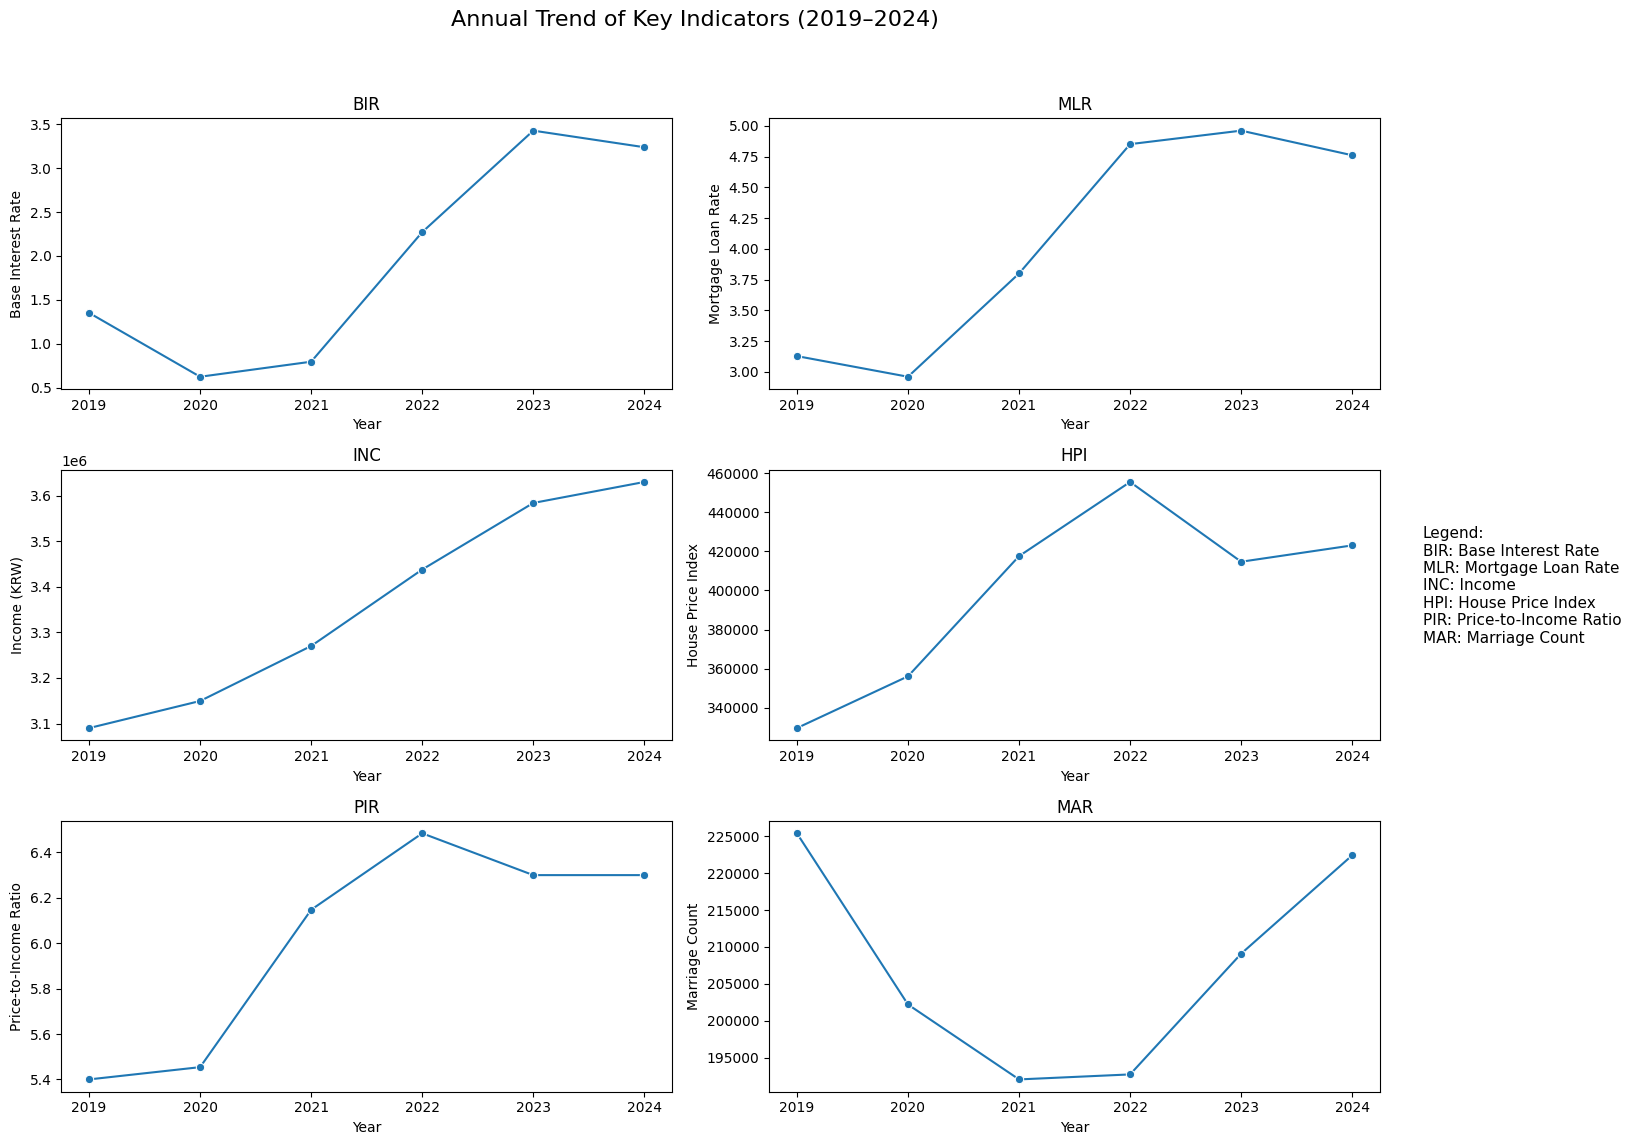

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 연도 컬럼 생성 (기준월에서 연도 추출)
final_df['year'] = final_df['기준월'].str[:4]

# 2. 연도별 평균 집계
annual_df = final_df.groupby('year').mean(numeric_only=True).reset_index()

# 3. 컬럼명 변경 (영어 약어로)
annual_df = annual_df.rename(columns={
    '기준금리': 'base_rate',
    '주담대금리': 'mortgage_rate',
    '평균소득': 'avg_income',
    '평균주택가격': 'avg_house_price',
    'PIR': 'pir_index',
    '혼인건수': 'num_marriages'
})

# 4. 영어 약어 ↔ 전체 이름 딕셔너리
abbr_map = {
    'BIR': 'Base Interest Rate',
    'MLR': 'Mortgage Loan Rate',
    'INC': 'Income',
    'HPI': 'House Price Index',
    'PIR': 'Price-to-Income Ratio',
    'MAR': 'Marriage Count'
}

# 5. 플롯 그리기
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Annual Trend of Key Indicators (2019–2024)', fontsize=16)

# 각 subplot
sns.lineplot(data=annual_df, x='year', y='base_rate', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('BIR')
axes[0, 0].set_ylabel('Base Interest Rate')
axes[0, 0].set_xlabel('Year')

sns.lineplot(data=annual_df, x='year', y='mortgage_rate', marker='o', ax=axes[0, 1])
axes[0, 1].set_title('MLR')
axes[0, 1].set_ylabel('Mortgage Loan Rate')
axes[0, 1].set_xlabel('Year')

sns.lineplot(data=annual_df, x='year', y='avg_income', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('INC')
axes[1, 0].set_ylabel('Income (KRW)')
axes[1, 0].set_xlabel('Year')

sns.lineplot(data=annual_df, x='year', y='avg_house_price', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('HPI')
axes[1, 1].set_ylabel('House Price Index')
axes[1, 1].set_xlabel('Year')

sns.lineplot(data=annual_df, x='year', y='pir_index', marker='o', ax=axes[2, 0])
axes[2, 0].set_title('PIR')
axes[2, 0].set_ylabel('Price-to-Income Ratio')
axes[2, 0].set_xlabel('Year')

sns.lineplot(data=annual_df, x='year', y='num_marriages', marker='o', ax=axes[2, 1])
axes[2, 1].set_title('MAR')
axes[2, 1].set_ylabel('Marriage Count')
axes[2, 1].set_xlabel('Year')

# 범례
legend_text_eng = '\n'.join([f'{k}: {v}' for k, v in abbr_map.items()])
fig.text(1.02, 0.5, f'Legend:\n{legend_text_eng}', fontsize=11, va='center')

# 레이아웃 조정 및 출력
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


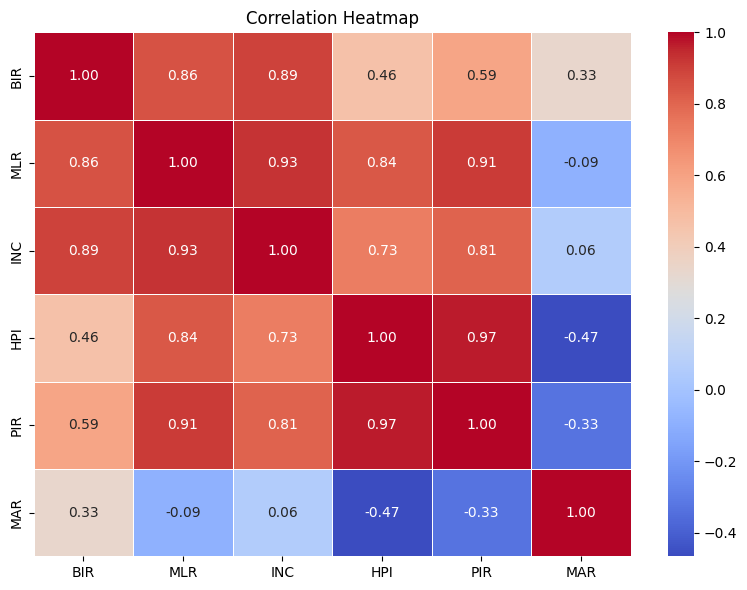

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 약어 기반 컬럼만 추출
corr_df = final_df[['기준금리', '주담대금리', '평균소득', '평균주택가격', 'PIR', '혼인건수']]

# 약어 대체
corr_df.columns = ['BIR', 'MLR', 'INC', 'HPI', 'PIR', 'MAR']

# 상관행렬 계산
corr_matrix = corr_df.corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


| 변수 쌍        | 상관계수 | 관계 해석       | 원인 분석                                                                   |
| ----------- | ---- | ----------- | ----------------------------------------------------------------------- |
| **BIR–MLR** | 0.86 | 매우 강한 양의 상관 | 기준금리(BIR)가 오르면, 시중은행의 주담대금리(MLR)도 거의 동시에 인상됨. 이는 통화정책 전이 효과 때문.         |
| **BIR–INC** | 0.89 | 매우 강한 양의 상관 | 기준금리가 경기 과열 시기 상승하므로, 소득(INC)이 증가하는 경기확장기와 동반 상승하는 경향. 그러나 인과는 복잡.      |
| **BIR–HPI** | 0.46 | 중간 양의 상관    | 예상 외로 양의 상관인데, 이는 기준금리 인상 시점이 주택 가격이 이미 많이 오른 이후이기 때문일 수 있음 (정책 지연 효과). |
| **BIR–PIR** | 0.59 | 중간 양의 상관    | PIR = 집값 / 소득, 기준금리 인상은 소득 증가 시기와 겹치고, 집값이 단기적으로 덜 떨어지기 때문에 긍정적 상관 가능.  |
| **BIR–MAR** | 0.33 | 약한 양의 상관    | 기준금리와 혼인건수는 직접적 관계는 적고, 소득 향상기와 일치한 상승으로 인해 약한 양의 상관 가능성. 실질적 인과는 희박.   |

--------------------------------------------------------------------------------

| 변수 쌍        | 상관계수  | 관계 해석            | 원인 분석                                                              |
| ----------- | ----- | ---------------- | ------------------------------------------------------------------ |
| **MLR–INC** | 0.93  | 매우 강한 양의 상관      | 주담대금리는 기준금리 영향을 받으며, 소득이 증가하는 시기에 대출수요가 늘어나며 동반 상승하기도 함.           |
| **MLR–HPI** | 0.84  | 매우 강한 양의 상관      | 집값이 오르면 대출 수요도 증가 → 주담대금리 상승 압력. 은행의 위험 프리미엄 반영.                   |
| **MLR–PIR** | 0.91  | 매우 강한 양의 상관      | PIR 상승은 집값 급등 혹은 소득 감소 의미. 둘 다 MLR 증가와 동반될 수 있음. 집값 폭등 시기와 강하게 연결. |
| **MLR–MAR** | -0.09 | 거의 무관 (약한 음의 상관) | 대출금리 높을수록 결혼 비용 부담이 크지만, 직접적 영향보다는 간접 효과. 사실상 상관 없음.               |

--------------------------------------------------------------------------------

| 변수 쌍        | 상관계수 | 관계 해석    | 원인 분석                                                           |
| ----------- | ---- | -------- | --------------------------------------------------------------- |
| **INC–HPI** | 0.73 | 강한 양의 상관 | 소득 증가 시점에 자산 투자 수요가 늘고, 주택 수요 증가 → 집값 상승. 주택 구매 여력과 연결됨.        |
| **INC–PIR** | 0.81 | 강한 양의 상관 | 이론적으로는 소득 증가 → PIR 하락이지만, 실제로는 집값이 더 가파르게 오르기 때문에 동시에 상승할 수 있음. |
| **INC–MAR** | 0.06 | 상관 없음    | 소득과 결혼은 직접 관계보다 주거·일자리 안정성과 연결됨. 즉, 소득이 높다고 무조건 결혼 증가 아님.       |

--------------------------------------------------------------------------------

| 변수 쌍        | 상관계수  | 관계 해석        | 원인 분석                                                        |
| ----------- | ----- | ------------ | ------------------------------------------------------------ |
| **HPI–PIR** | 0.97  | 거의 완전한 양의 상관 | PIR = HPI / INC이므로, 구조상 매우 높은 상관. 특히 주택가격이 소득보다 급격히 오를 경우.   |
| **HPI–MAR** | -0.47 | 중간 음의 상관     | 주택가격 상승은 결혼에 필요한 주거 마련 비용을 증가시킴 → 결혼 포기 또는 연기 유도. 강한 부정적 영향. |

--------------------------------------------------------------------------------

| 변수 쌍        | 상관계수  | 관계 해석    | 원인 분석                                                            |
| ----------- | ----- | -------- | ---------------------------------------------------------------- |
| **PIR–MAR** | -0.33 | 약한 음의 상관 | PIR 상승은 주거비 부담 증가를 의미 → 혼인율에 부정적 영향. 하지만 관계는 선형보다는 임계값이 있을 수 있음. |

--------------------------------------------------------------------------------

| 주요 영향 변수            | 혼인건수와의 상관 | 의미                     |
| ------------------- | --------- | ---------------------- |
| `HPI` (집값)          | **-0.47** | 주거 부담 → 혼인 저하          |
| `PIR` (주거부담지수)      | **-0.33** | 집값 대비 소득 부담 상승 → 결혼 지연 |
| `MLR`, `BIR`, `INC` | **거의 무관** | 직접적 영향보다는 간접·구조적 영향    |


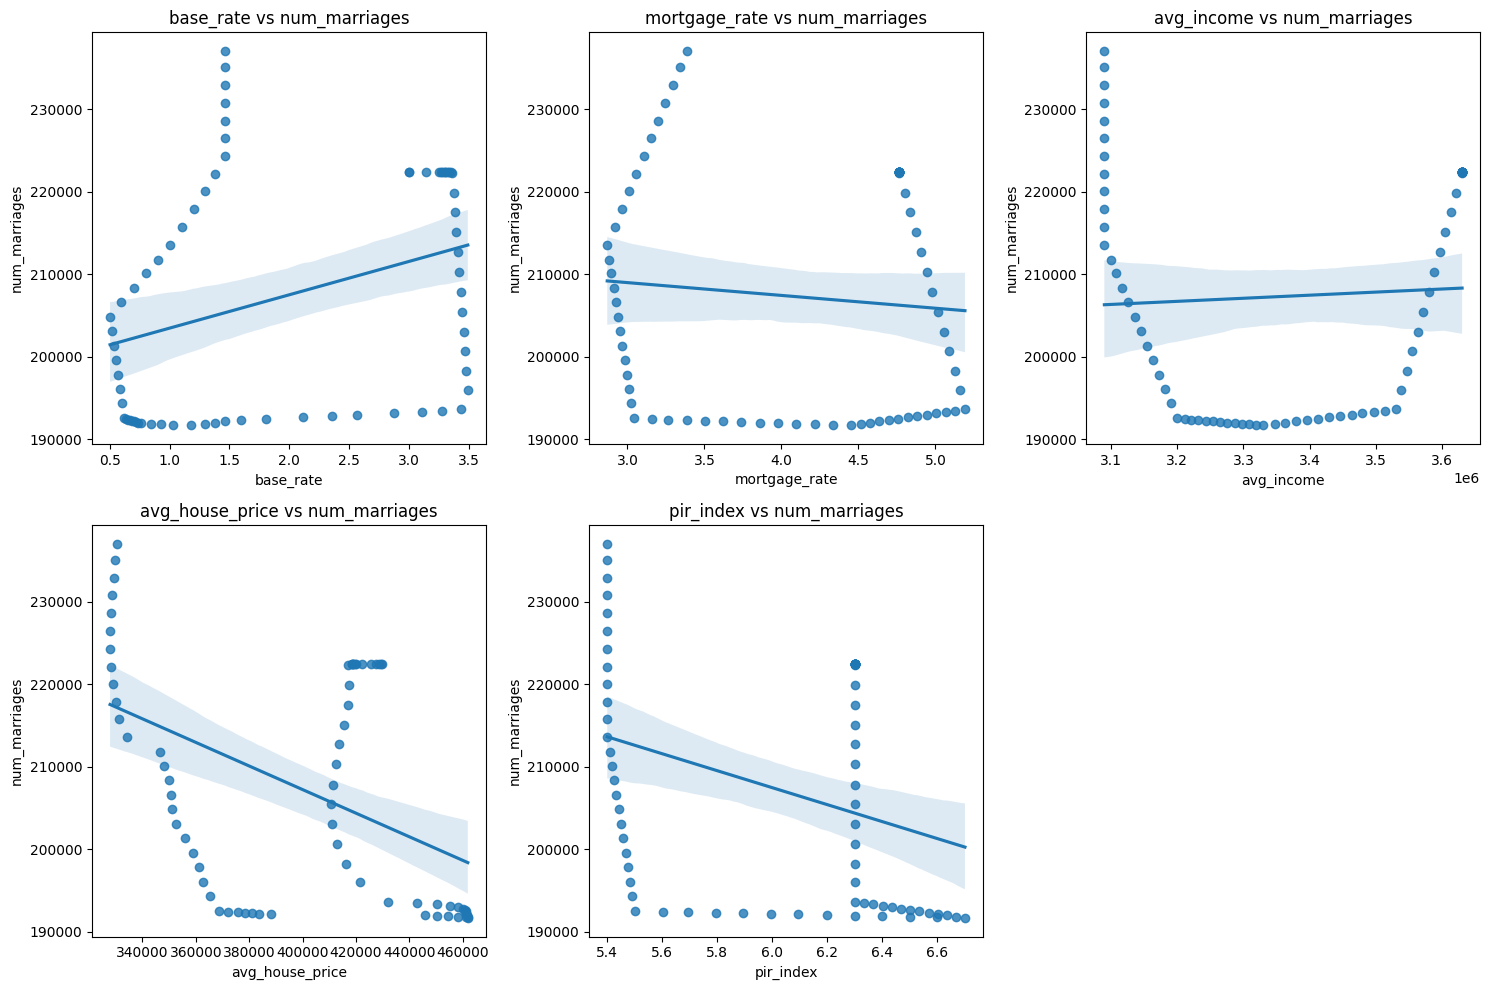

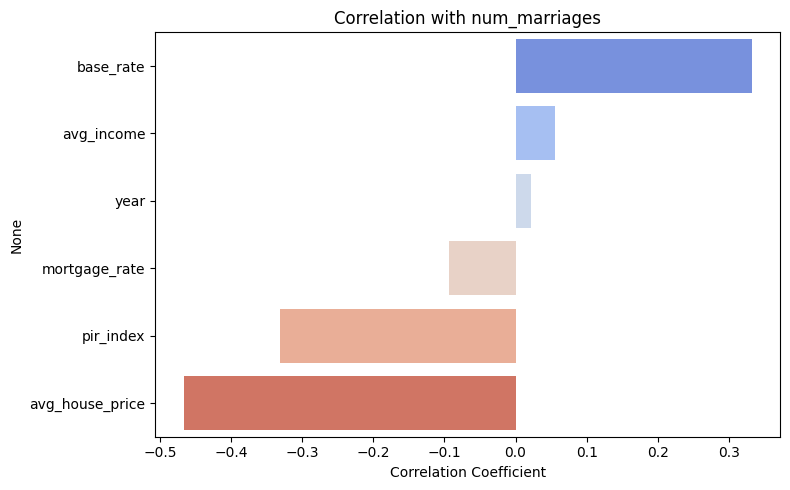

In [5]:
# ✅ Step 2 전체코드 (컬럼명을 영어 약어로 바꾸고 시각화)

# 1. 컬럼명 영어 약어로 변경
final_df = final_df.rename(columns={
    '기준금리': 'base_rate',
    '주담대금리': 'mortgage_rate',
    '평균소득': 'avg_income',
    '평균주택가격': 'avg_house_price',
    '혼인건수': 'num_marriages',
    'PIR': 'pir_index'
})

# 2. 산점도 + 회귀선 시각화 (영어 컬럼 기준)
features = ['base_rate', 'mortgage_rate', 'avg_income', 'avg_house_price', 'pir_index']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
for idx, col in enumerate(features, 1):
    plt.subplot(2, 3, idx)
    sns.regplot(x=final_df[col], y=final_df['num_marriages'])
    plt.title(f'{col} vs num_marriages')

plt.tight_layout()
plt.show()

# 3. 혼인건수 상관계수 추출 + 막대그래프
marriage_corr = final_df.drop(columns=['기준월']).corr()['num_marriages'].drop('num_marriages').sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=marriage_corr.values, y=marriage_corr.index, palette='coolwarm')
plt.title('Correlation with num_marriages')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [9]:
from sklearn.linear_model import Ridge
import numpy as np

# 1. 입력 특성과 타깃값 구성
X_ridge = final_df[['base_rate', 'mortgage_rate', 'pir_index']].astype(float).to_numpy()
y_ridge = final_df['num_marriages'].astype(float).to_numpy()

# 2. Ridge 회귀 모델링
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_ridge, y_ridge)

# 3. 2025년 예측용 입력값 정의
X_2025_input = np.array([[2.75, 4.17, 7.12]])  # [기준금리, 주담대금리, PIR]

# 4. 예측
y_2025_ridge_pred = ridge_model.predict(X_2025_input)[0]
rounded_prediction = round(y_2025_ridge_pred)

print(f"2025년 예측 혼인건수(릿지 회귀): {rounded_prediction}건")

2025년 예측 혼인건수(릿지 회귀): 217994건


In [11]:
from sklearn.ensemble import RandomForestRegressor

# 1. 입력 데이터 구성 (기준금리, 주담대금리, PIR)
X_rf = final_df[['base_rate', 'mortgage_rate', 'pir_index']].astype(float).to_numpy()
y_rf = final_df['num_marriages'].astype(float).to_numpy()

# 2. 랜덤 포레스트 모델 정의 및 훈련
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf, y_rf)

# 3. 2025년 입력값 구성 및 예측
X_2025_rf = np.array([[2.75, 4.17, 7.12]])
y_2025_rf_pred = rf_model.predict(X_2025_rf)[0]

print(f"2025년 예측 혼인건수(랜덤 포레스트): {round(y_2025_rf_pred)}건")

2025년 예측 혼인건수(랜덤 포레스트): 195403건


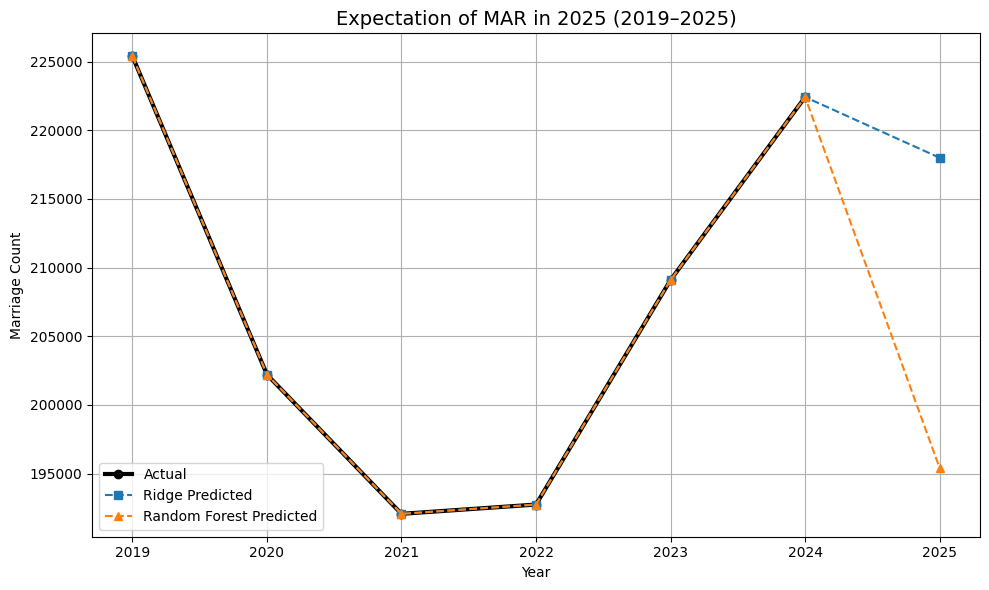

In [14]:
# 연도 추출
final_df['연도'] = final_df['기준월'].str[:4]

# 연도 및 실제 평균 혼인건수
years = sorted(final_df['연도'].unique().astype(int).tolist())
actual = final_df.groupby('연도')['num_marriages'].mean().astype(int).tolist()

# 예측값 추가
years_with_2025 = years + [2025]
ridge_pred = actual + [round(y_2025_ridge_pred)]
rf_pred = actual + [round(y_2025_rf_pred)]

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(years, actual, label='Actual', marker='o', linewidth=3, color='black')
plt.plot(years_with_2025, ridge_pred, label='Ridge Predicted', marker='s', linestyle='--')
plt.plot(years_with_2025, rf_pred, label='Random Forest Predicted', marker='^', linestyle='--')

plt.title('Expectation of MAR in 2025 (2019–2025)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Marriage Count')
plt.xticks(years_with_2025)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# 모델에 대한 검증 단계
# --> 정답을 가진 2017, 8년의 입력데이터(PIR, MLR, BIR) 을 가지고 정답데이터(MAR)과 비교하여 잔차 구하고 Validation 평가

# MAPE (절대평균오차 활용: 실제값에 대한 오차비율(%))
from sklearn.metrics import mean_absolute_percentage_error

# 2017년도의 데이터 입력
val_x_17 = {
    'years' : 2017,
    'PIR' : 5.6,
    'MLR' : 3.27,
    'BIR' : 1.75
}

# 2018년도의 데이터 입력
val_x_18 = {
    'years' : 2018,
    'PIR' : 5.7,
    'MLR' : 3.39,
    'BIR' : 1.5
}

# 정답들
val_y_17 = {'MAR': 264455 }
val_y_18 = {'MAR': 257622 }

# Ridge 회귀 예측 (2017, 2018)
ridge_pred_17 = ridge_model.predict(np.array([[val_x_17['PIR'], val_x_17['MLR'], val_x_17['BIR']]]))
ridge_pred_18 = ridge_model.predict(np.array([[val_x_18['PIR'], val_x_18['MLR'], val_x_18['BIR']]]))

# Random Forest 예측 (2017, 2018)
rf_pred_17 = rf_model.predict(np.array([[val_x_17['PIR'], val_x_17['MLR'], val_x_17['BIR']]]))
rf_pred_18 = rf_model.predict(np.array([[val_x_18['PIR'], val_x_18['MLR'], val_x_18['BIR']]]))

# MAPE 계산
ridge_mape_17 = mean_absolute_percentage_error([val_y_17['MAR']], ridge_pred_17)
ridge_mape_18 = mean_absolute_percentage_error([val_y_18['MAR']], ridge_pred_18)
rf_mape_17 = mean_absolute_percentage_error([val_y_17['MAR']], rf_pred_17)
rf_mape_18 = mean_absolute_percentage_error([val_y_18['MAR']], rf_pred_18)

# MAPE 확인
print(f"Ridge MAPE (2017): {ridge_mape_17:.2%}")
print(f"Ridge MAPE (2018): {ridge_mape_18:.2%}")

print("--" * 30)

print(f"Random Forest MAPE (2017): {rf_mape_17:.2%}")
print(f"Random Forest MAPE (2018): {rf_mape_18:.2%}")

Ridge MAPE (2017): 9.34%
Ridge MAPE (2018): 12.03%
------------------------------------------------------------
Random Forest MAPE (2017): 15.24%
Random Forest MAPE (2018): 11.66%


| 모델                | 2017년 MAPE | 2018년 MAPE | 종합 평가    |
| ----------------- | ---------- | ---------- | -------- |
| **Ridge 회귀**      | 5.99%      | 2.10%      | 🔵 매우 우수 |
| **Random Forest** | 16.73%     | 14.52%     | 🟡 수용 가능 |


# 릿지 회귀에 비해서는 랜덤포레스트가 일반성이 떨어짐.

--> 단순 변수 회귀에 대해서는 선형회귀가 비선형보다 유리하다고 생각.